# Bank Churn Analysis and Classifier

## Evaluation Metric

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

### Notes

Will put any notes here

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
df_train = pd.read_csv('./Data/train.csv')
df_test = pd.read_csv('./Data/test.csv')

In [3]:
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


### Data exploration

It looks like we have columns CustomerId and Surname that won't be useful in our analysis as they are largely unique and will not be predictive.

Lets check the rest of the variables below

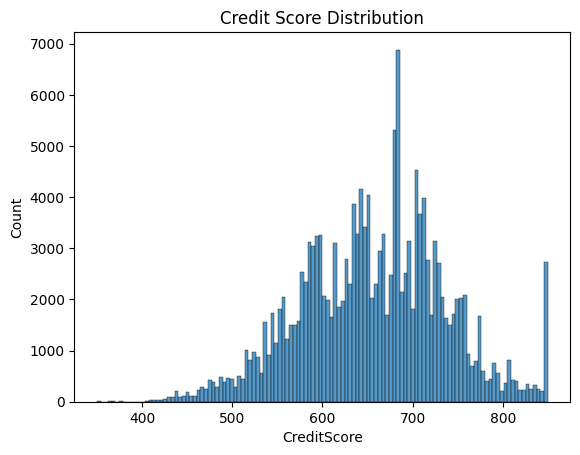

In [4]:
sns.histplot(data=df_train, x='CreditScore')
plt.title('Credit Score Distribution')
plt.show()

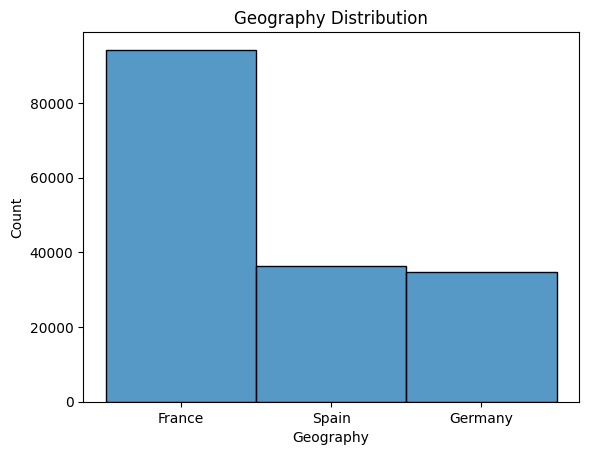

In [5]:
sns.histplot(data=df_train, x='Geography')
plt.title('Geography Distribution')
plt.show()

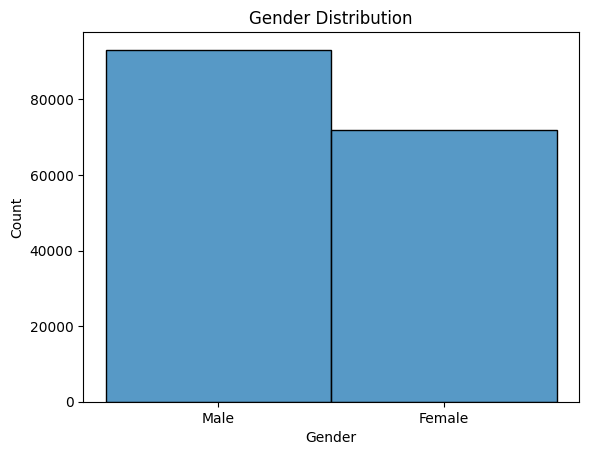

In [6]:
sns.histplot(data=df_train, x='Gender')
plt.title('Gender Distribution')
plt.show()

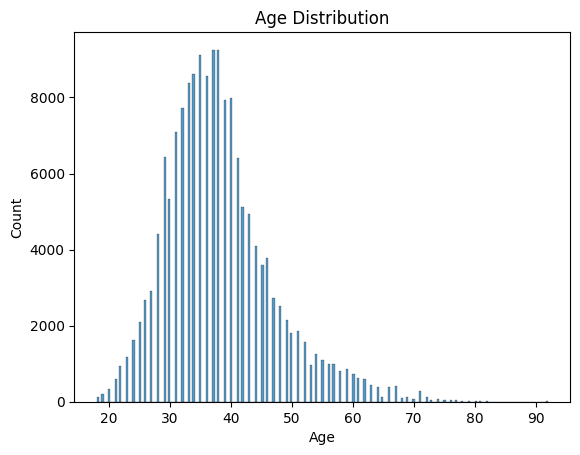

In [7]:
sns.histplot(data=df_train, x='Age')
plt.title('Age Distribution')
plt.show()

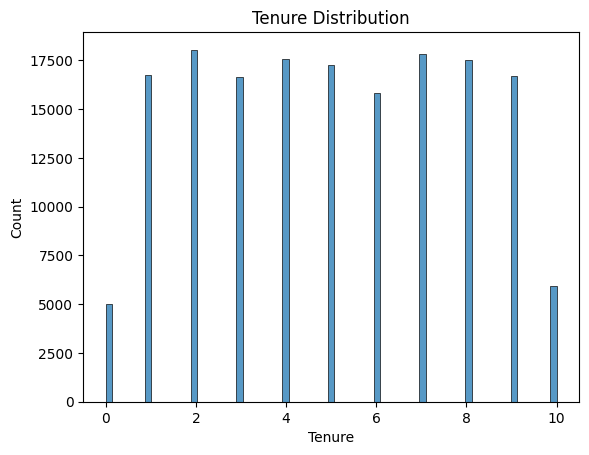

In [8]:
sns.histplot(data=df_train, x='Tenure')
plt.title('Tenure Distribution')
plt.show()

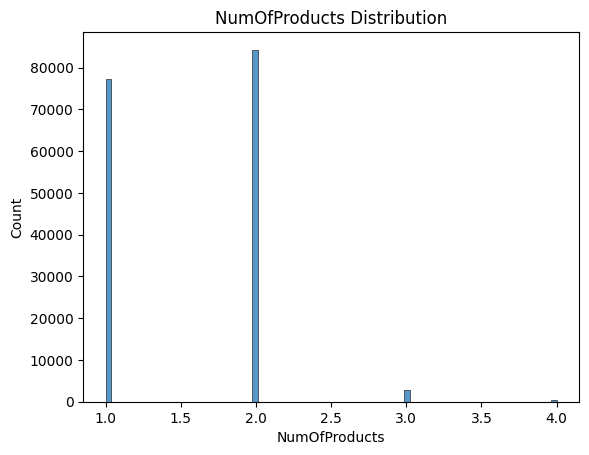

In [9]:
sns.histplot(data=df_train, x='NumOfProducts')
plt.title('NumOfProducts Distribution')
plt.show()

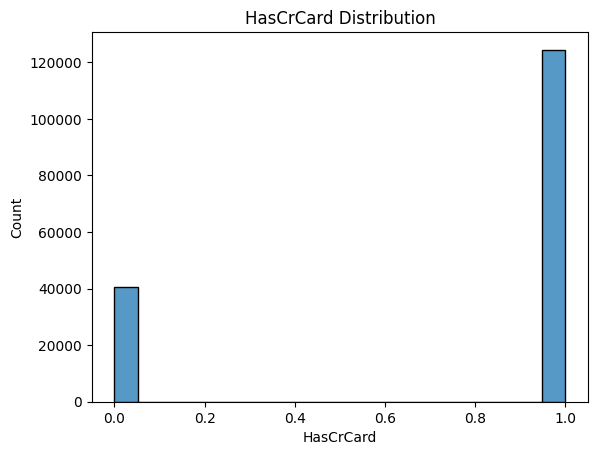

In [10]:
sns.histplot(data=df_train, x='HasCrCard')
plt.title('HasCrCard Distribution')
plt.show()

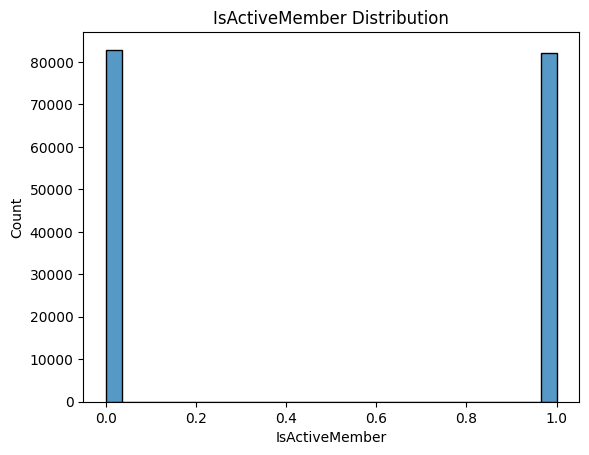

In [11]:
sns.histplot(data=df_train, x='IsActiveMember')
plt.title('IsActiveMember Distribution')
plt.show()

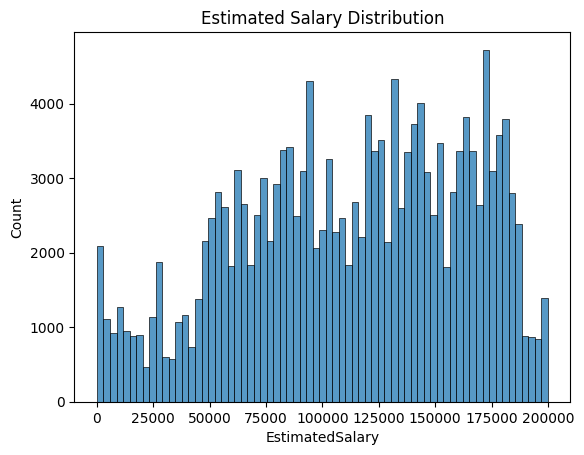

In [12]:
sns.histplot(data=df_train, x='EstimatedSalary')
plt.title('Estimated Salary Distribution')
plt.show()

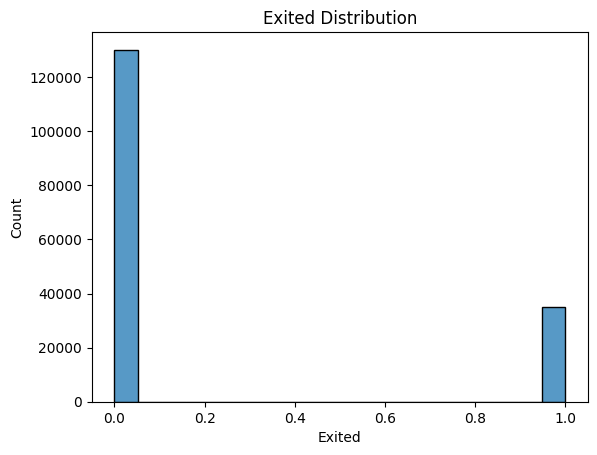

In [13]:
sns.histplot(data=df_train, x='Exited')
plt.title('Exited Distribution')
plt.show()

<Axes: >

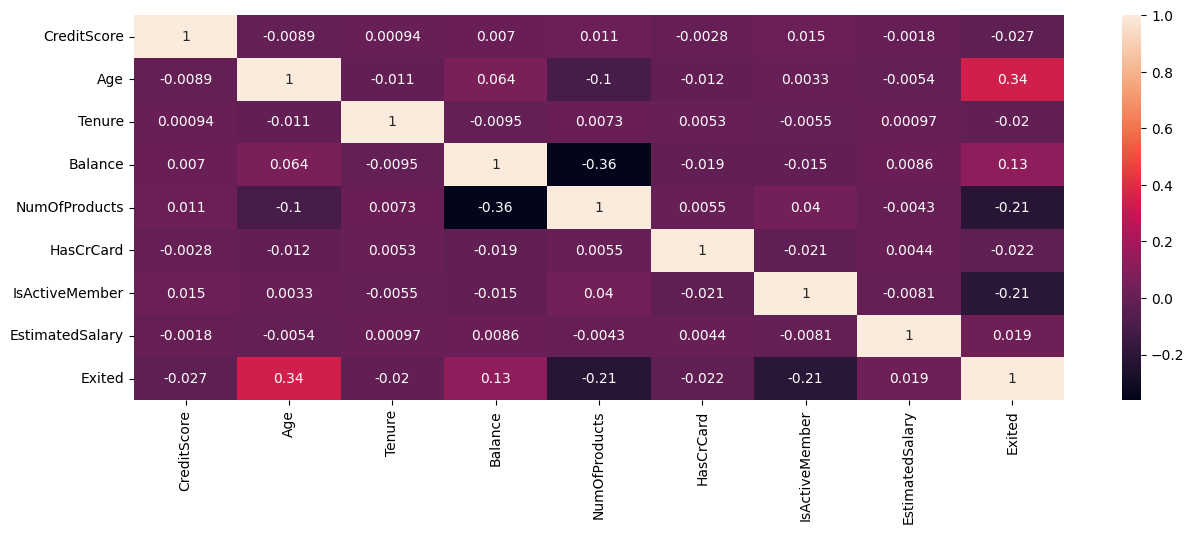

In [14]:
plt.figure(figsize=(15,5))
sns.heatmap(df_train[['CreditScore', 'Age',
                      'Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary','Exited']].corr(), annot=True)

Of the numerical variables, it looks like Age is the most highly correlated with Exiting. Num products and IsActive Member are both the highest negatively correlated features.

In [15]:
## Check For nulls and duplicates
df_train.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [16]:
df_train.duplicated().sum()

0

## Data Preprocessing

There are a few things I want to do to the datasets to prepare them.

1. Remove CustomerId and Surname
2. Apply a scaler to some of the numerical values. In particular CreditScore, Balance, and Estimated Salary
3. I want to transform HasCrCard and IsActiveMember to True/False
4. Leave Age, Tenure, and NumOfProducts alone

In [17]:
def preprocessing(df0):
    df = df0.copy()

    # Remove CustomerId, Surname
    df.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

    # Transform HasCC and ActiveMem to True/False
    df['HasCrCard'] = df['HasCrCard'].astype(bool)
    df['IsActiveMember'] = df['IsActiveMember'].astype(bool)

    # Apply the scaler to these columns
    scaler = MinMaxScaler()
    df[['CreditScore', 'Balance', 'EstimatedSalary']] = scaler.fit_transform(df[['CreditScore', 'Balance', 'EstimatedSalary']])

    # Create dummies for the categorical features
    columns_to_dummies = ["Geography", "Gender", "HasCrCard", "IsActiveMember"]
    df_dummies = pd.get_dummies(df, columns=columns_to_dummies)

    return df_dummies

In [18]:
df_train_preprocess = preprocessing(df_train)

# Convert Exited to float for modeling, exited wont be present in test
df_train_preprocess['Exited'] = df_train_preprocess['Exited'].astype(float)

df_train_preprocess.head()

,id,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_False,HasCrCard_True,IsActiveMember_False,IsActiveMember_True
0,0,0.636,33.0,3,0.000000,2,0.907279,0.0,True,False,False,False,True,False,True,True,False
1,1,0.554,33.0,1,0.000000,2,0.247483,0.0,True,False,False,False,True,False,True,False,True
2,2,0.656,40.0,10,0.000000,2,0.924364,0.0,True,False,False,False,True,False,True,True,False
3,3,0.462,34.0,2,0.593398,1,0.422787,0.0,True,False,False,False,True,False,True,False,True
4,4,0.732,33.0,5,0.000000,2,0.075293,0.0,False,False,True,False,True,False,True,False,True


## Modeling

It looks like we have a good set of training data to train an XGBClassifier

In [19]:
from sklearn.model_selection import train_test_split

y = df_train_preprocess['Exited']

X = df_train_preprocess.copy()
X.drop('Exited', axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
X_train.head()

(132027, 16)
(33007, 16)
(132027,)
(33007,)


,id,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_False,HasCrCard_True,IsActiveMember_False,IsActiveMember_True
86674,86674,0.458,39.0,2,0.323929,2,0.093549,False,True,False,True,False,False,True,True,False
131282,131282,0.402,49.0,5,0.394964,1,0.817601,True,False,False,False,True,False,True,True,False
44626,44626,0.368,30.0,8,0.000000,1,0.367883,True,False,False,True,False,False,True,False,True
142082,142082,0.622,55.0,5,0.387880,1,0.392060,False,True,False,False,True,False,True,True,False
36552,36552,0.722,47.0,5,0.000000,1,0.809569,True,False,False,True,False,False,True,True,False


In [25]:
# Create a gridsearch to find the best model parameters
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

xgb = XGBClassifier(objective='binary:logistic', random_state=1337)

# Define the parameter grid
param_grid = {
    'max_depth': [2, 3, 5, None],
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

scoring_params = ['accuracy', 'precision', 'recall', 'f1']

xgb_gs = GridSearchCV(xgb, scoring=scoring_params, cv=3, param_grid=param_grid, refit='f1')

xgb_gs.fit(X_train, y_train)

c:\Users\rsvag\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rsvag\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rsvag\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=1337, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [2, 3, 5, None],
                         'n_estimators': range(60, 220, 40)},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [26]:
# Find the best model
print('Best params: ', xgb_gs.best_params_)
print('Best score: ', xgb_gs.best_score_)
print('Best estimator', xgb_gs.best_estimator_)

xgb_optimal = xgb_gs.best_estimator_

Best params:  {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 180}
Best score:  0.6394984027558395
Best estimator XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, random_state=1337, ...)


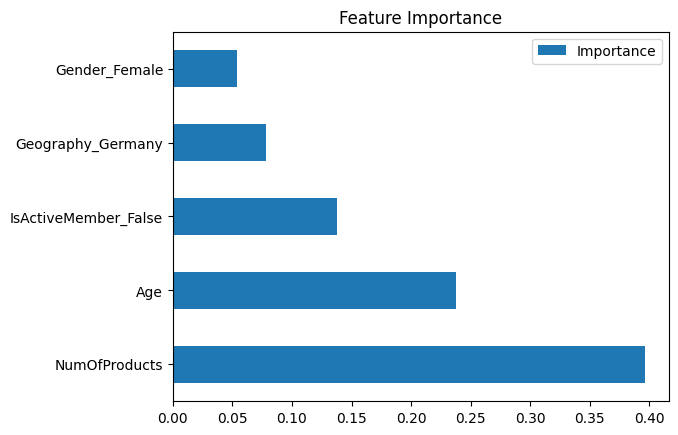

In [27]:
# Show the feature importances
feature_imp = pd.DataFrame(data=xgb_optimal.feature_importances_, index=xgb_optimal.feature_names_in_)
feature_imp.columns=['Importance']

feature_imp['Importance'] = feature_imp['Importance']
feature_imp

feature_imp.nlargest(5, 'Importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [33]:
# Run on the X_test data
test_xgb_optimal_preds = xgb_optimal.predict_proba(X_test)[:, 1]

test_xgb_optimal_preds

array([0.01006876, 0.02264667, 0.21313122, ..., 0.6320807 , 0.4806255 ,
       0.08904298], dtype=float32)

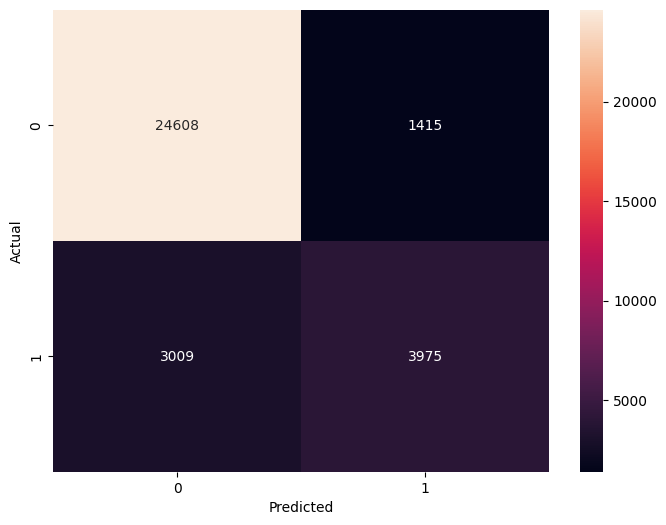

In [34]:
from sklearn.metrics import confusion_matrix

# Need to make my predictions binary
test_xgb_optimal_preds_bin = (test_xgb_optimal_preds > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, test_xgb_optimal_preds_bin)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_test, test_xgb_optimal_preds_bin)
precision = precision_score(y_test, test_xgb_optimal_preds_bin)
recall = recall_score(y_test, test_xgb_optimal_preds_bin)
f1 = f1_score(y_test, test_xgb_optimal_preds_bin)
ruc = roc_auc_score(y_test, test_xgb_optimal_preds)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", ruc)

Accuracy: 0.8659678250068167
Precision: 0.7374768089053804
Recall: 0.5691580756013745
F1 Score: 0.642476159689672
ROC AUC Score: 0.8897522871542087


# Use to predict on the test data

It looks like the model could use a little work, but I'll give it a submission

In [39]:
df_test_preprocessed = preprocessing(df_test)

test_preds = xgb_optimal.predict_proba(df_test_preprocessed)[:, 1]

In [42]:
df_test_preprocessed['Exited'] = test_preds

In [43]:
df_test_preprocessed.head(10)

,id,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_False,HasCrCard_True,IsActiveMember_False,IsActiveMember_True,Predictions,Exited
0,165034,0.472,23.0,2,0.000000,2,0.804903,True,False,False,True,False,True,False,False,True,0.024238,0.024238
1,165035,0.666,46.0,2,0.000000,1,0.362723,True,False,False,True,False,False,True,True,False,0.760611,0.760611
2,165036,0.612,34.0,7,0.000000,2,0.694419,True,False,False,True,False,False,True,True,False,0.018336,0.018336
3,165037,0.662,36.0,8,0.000000,1,0.569654,True,False,False,False,True,False,True,True,False,0.226048,0.226048
4,165038,0.804,38.0,10,0.483318,1,0.697164,False,True,False,False,True,False,True,True,False,0.342846,0.342846
5,165039,0.486,22.0,9,0.000000,2,0.259505,True,False,False,True,False,True,False,True,False,0.053409,0.053409
6,165040,0.664,45.0,4,0.000000,2,0.789411,False,False,True,False,True,False,True,False,True,0.038662,0.038662
7,165041,0.378,47.0,8,0.000000,2,0.633924,False,False,True,True,False,False,True,False,True,0.089462,0.089462
8,165042,0.990,47.0,3,0.442797,1,0.474878,True,False,False,True,False,False,True,True,False,0.602489,0.602489
9,165043,0.590,30.0,5,0.000000,2,0.745991,False,False,True,False,True,True,False,False,True,0.014160,0.014160


In [44]:
df_submission = df_test_preprocessed[['id', 'Exited']]

In [47]:
df_submission.tail()

,id,Exited
110018,275052,0.040990
110019,275053,0.119594
110020,275054,0.016802
110021,275055,0.141611
110022,275056,0.159471


In [48]:
df_submission.to_csv('submission_1.csv', index=False)

## Entry

This first entry put me in the middle of the leaderboard with a evaluation metric score of 0.88493.